## Probelm Definition

##### `Goal`: Predict whether a passenger survived the Titanic disaster (binary classification).
- Load, inspect, and understand a real-world dataset. 
- Identify and handle missing values and inconsistencies. 
- Perform basic data cleaning and feature engineering. 
- Conduct exploratory data analysis (EDA) with visualizations. 
- Build a simple model to demonstrate how the cleaned data can be used for prediction

##### `Business Value`: Such modeling mimics real-world survival analysis → can inform safety planning, risk prediction.

##### Import Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

- Features include:

    - PassengerId, Name, Age, Sex, Pclass (ticket class), Fare, Cabin, Embarked, SibSp, Parch, Survived (target).

##### Data Collection

In [49]:
# Load Dataset
df = pd.read_csv("dataset/train.csv")  
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Data Inspection

In [50]:
# Datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [51]:
# Statistical Summary
print("Shape:", df.shape)
df.describe()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [52]:
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [53]:
# Checking Missing data
missing_data = []
for column_name, null_rows in df.isnull().sum().items():
    if null_rows > 0:
        perc = null_rows / len(df) * 100
        missing_data.append([column_name, null_rows, perc])

missing_df = pd.DataFrame(missing_data, columns=["Column", "Missing Values", "Percentage"])
missing_df

,Column,Missing Values,Percentage
0,Age,177,19.865320
1,Cabin,687,77.104377
2,Embarked,2,0.224467


In [54]:
# Checking for Duplicates
print(f'Number of duplicated rows: {df.duplicated().sum(axis=0)}')

Number of duplicated rows: 0


- Dataset contains 891 records with 12 columns
- Features include Passenger details (Name, Sex, Age, Fare, Pclass, etc.).
- Datatypes: mixture of numeric (int, float) and categorical (object).
- Missing values in Age, Cabin, and Embarked.

##### Data Preprocessing

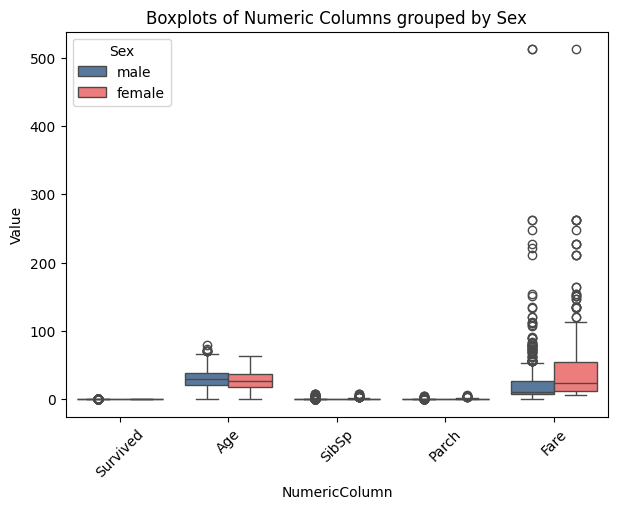

In [55]:
# outliers
cat_col = "Sex"

exclude_cols = ["PassengerId", "Pclass"]
num_cols = [col for col in df.select_dtypes(include="number").columns if col not in exclude_cols]
    
melted_df = df.melt(id_vars=cat_col, value_vars=num_cols, var_name="NumericColumn", value_name="Value").dropna()
custom_palette = {'male': '#4E79A7', 'female': '#FF6B6B'} 
plt.figure(figsize=(7, 5))
sns.boxplot(x="NumericColumn", y="Value", hue=cat_col, data=melted_df, palette=custom_palette)
plt.title(f"Boxplots of Numeric Columns grouped by {cat_col}")
plt.xticks(rotation=45)
plt.show()

In [56]:
# Handling Missing data
df["Age"] = SimpleImputer(strategy="median").fit_transform(df[["Age"]])
df["Fare"] = SimpleImputer(strategy="median").fit_transform(df[["Fare"]])
df["Embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["Embarked"]])[:,0]

# Checking missing data
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

- Outliers found in Age and Fare column
- Data imputaion
    - Age, Fare &rarr; median since they are numeric and skewed.
    - Embarked &rarr; most frequent since only 2 values missing.

##### Feature Engineering

In [57]:
# Title Extraction from Name column
def extract_title(name: str):
    import re
    m = re.search(r",\s*([^\.]+)\.", name)
    return m.group(1).strip() if m else "None"

df["Title"] = df["Name"].apply(extract_title)
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Royalty", "Countess": "Royalty", "Sir": "Royalty",
    "Jonkheer": "Royalty", "Don": "Royalty", "Dona": "Royalty",
    "Dr": "Officer", "Rev": "Officer", "Col": "Officer",
    "Major": "Officer", "Capt": "Officer"
}
df["Title"] = df["Title"].replace(title_map)

# Family features (family size, alone indicator)
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# Age groups
def age_group(age):
    if age < 18:
        return "Child"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"

df["AgeGroup"] = df["Age"].apply(age_group)

# Simplify Cabin → deck letter
df["Deck"] = df["Cabin"].astype(str).str[0]
df["Deck"] = df["Deck"].replace("n", "Unknown")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,AgeGroup,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,Adult,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,Adult,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,Adult,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,Adult,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,Adult,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Officer,1,1,Adult,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,1,1,Adult,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,Miss,4,0,Adult,Unknown
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,1,1,Adult,C


- Title Extraction: passenger titles (Mr, Mrs, Miss, Master) from the Name column
- New Features:
    - FamilySize: captures group travel with siblings, spouse, parents and children.
    - IsAlone: binary indicator if the passenger was alone.
- Grouped Age into categories (child, adult, senior)
- Simplify Cabin by using only the first letter (deck)

##### Exploratory Data Analysis (EDA)

In [58]:
# Gender percentage of Total Passengers
gender_df =pd.concat(
    [
        df["Sex"].value_counts(), 
        df["Sex"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    ], axis=1, keys=["Total", "Percentage"]).reset_index()
gender_df

,Sex,Total,Percentage
0,male,577,64.76%
1,female,314,35.24%


- Out of 891 total passengers on board
    - The majority of passengers were men 65% 
    - Female passengers were only 35%

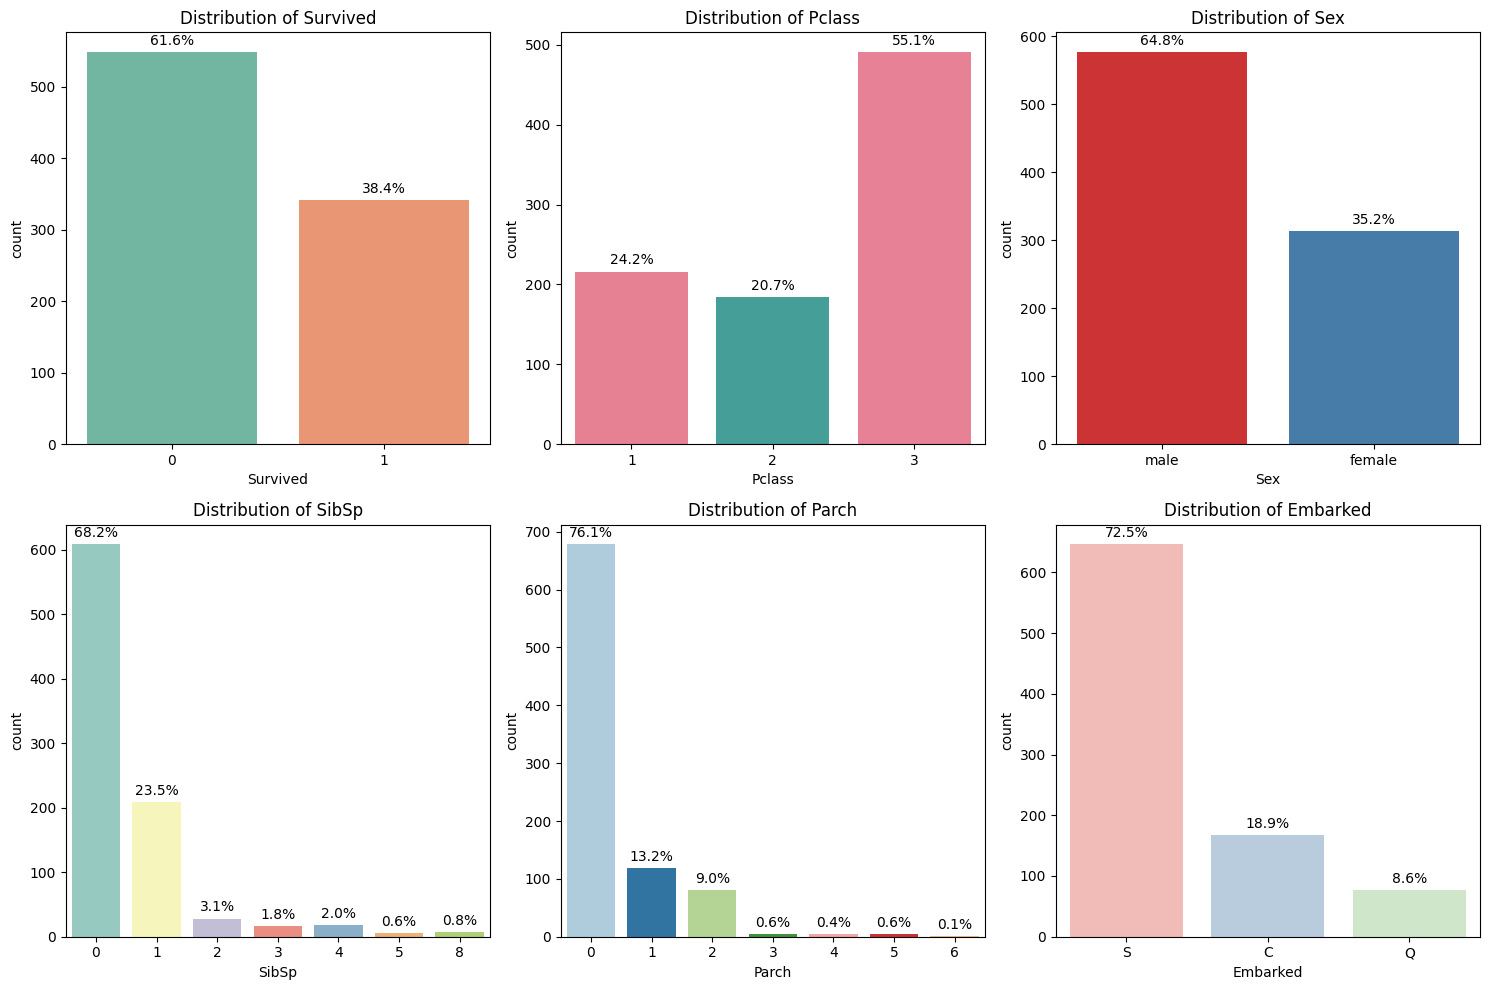

In [59]:
# Passenger distribution in each categories
categories = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]
palettes = ['Set2', 'husl', 'Set1', 'Set3', 'Paired', 'Pastel1']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()

total = len(df)

for i, category in enumerate(categories):
    ax = sns.countplot(data=df, x=category, hue=category, palette=palettes[i], dodge=False, legend=False, ax=axes[i])
    ax.set_title(f"Distribution of {category}")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = 100 * height / total
            ax.annotate(f'{percentage:.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black',
                        xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

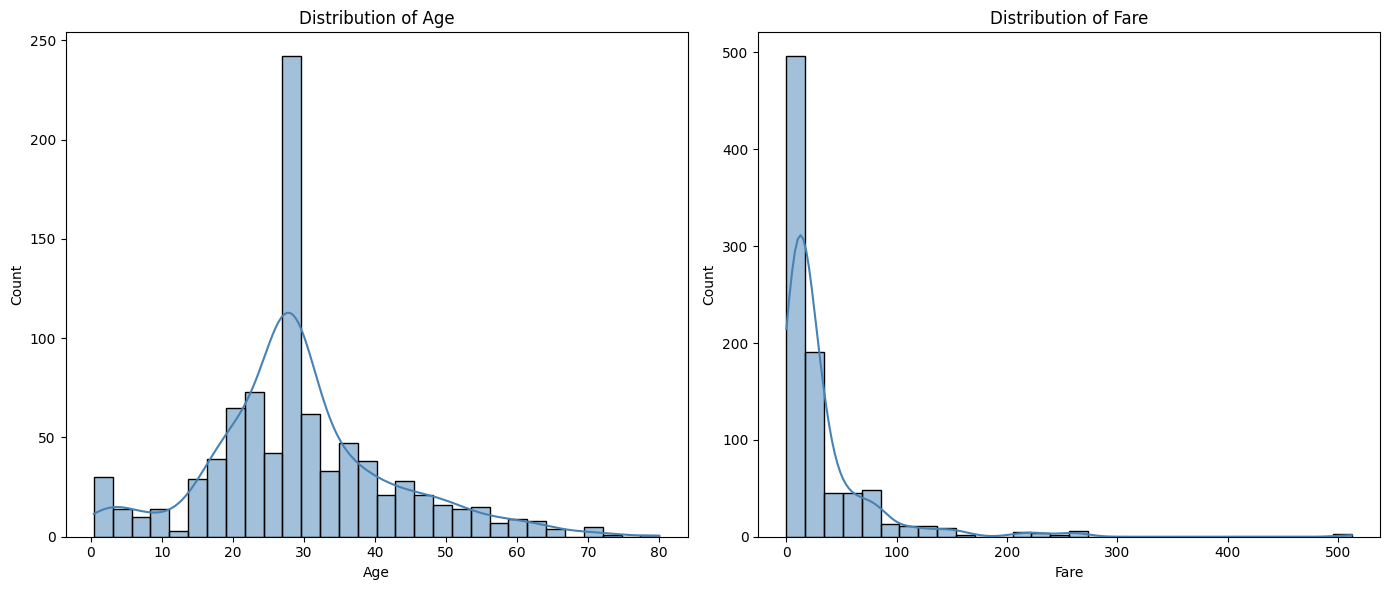

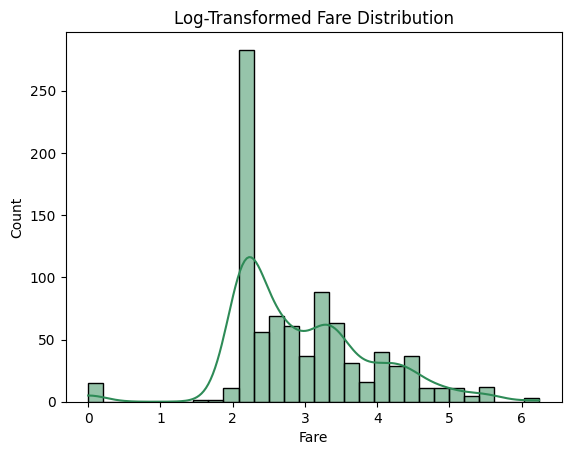

In [60]:
# Distribution of numerical attributes
numerical = ["Age", "Fare"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
total = len(df)

for i, num in enumerate(numerical):
    ax = sns.histplot(df[num], kde=True, bins=30, color="steelblue", ax=axes[i])
    ax.set_title(f"Distribution of {num}")

plt.tight_layout()
plt.show()

# log transformation for uniform data distribution of Fare

df['Fare'] = np.log(df['Fare']+1)
sns.histplot(df['Fare'], bins=30, kde=True, color='seagreen')

plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Log-Transformed Fare Distribution')
plt.show()

In [61]:
# Survival rate visualization
def visualize_survival_rate(plot_df, attr, ax, palette=None, title=None, labels=None):
    survived_df = plot_df[plot_df['Survived'] == 1]

    counts = survived_df[attr].value_counts()
    percentages = counts / counts.sum() * 100
    palette = sns.color_palette(palette, n_colors=len(counts))
    if labels is not None:
        counts.index = labels
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=counts.index,
        autopct=lambda p: f"{p:.2f}%",  
        startangle=90,
        colors=palette,
        wedgeprops={'width': 0.4} 
    )

    for text in autotexts:
        text.set_fontsize(10)

    ax.set_title(title)

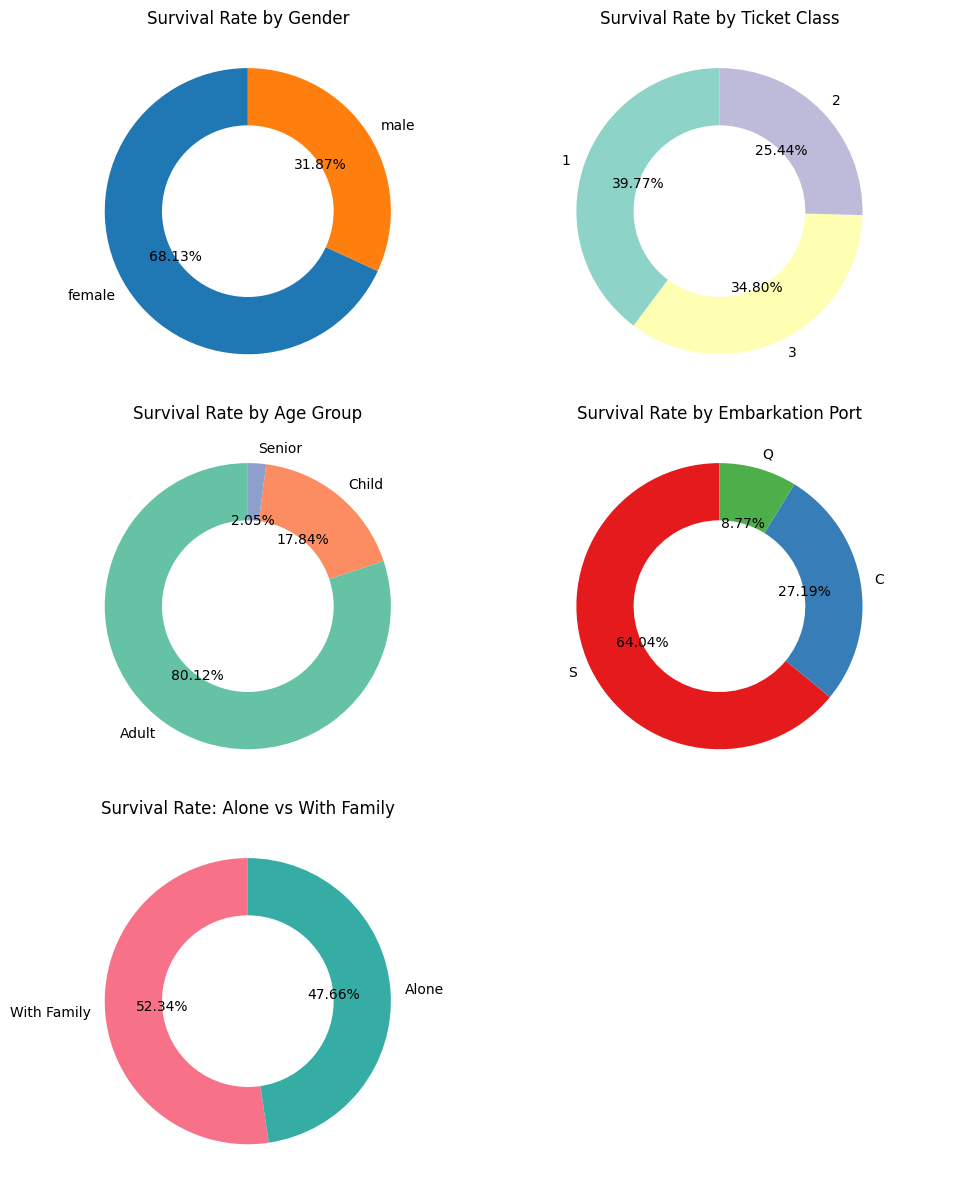

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

# Survival by Gender
visualize_survival_rate(df, attr="Sex", ax=axes[0], title="Survival Rate by Gender")

# Survival by Ticket Class
visualize_survival_rate(df, attr="Pclass", ax=axes[1], title="Survival Rate by Ticket Class", palette="Set3")

# Survival by Age Group
visualize_survival_rate(df, attr="AgeGroup", ax=axes[2], title="Survival Rate by Age Group", palette='Set2')

# Survival by Embarkation Port
visualize_survival_rate(df, attr="Embarked", ax=axes[3], title="Survival Rate by Embarkation Port", palette="Set1")

# Alone vs Family
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
visualize_survival_rate(df, attr="IsAlone", ax=axes[4], labels= ["With Family","Alone"], title="Survival Rate: Alone vs With Family", palette="husl")

# Hide the last empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [63]:
# Drop column
df = df.drop(columns=["Cabin"])

- Cabin &rarr; dropped due to excessive missing values.

In [64]:
# Encode categorical variables
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])

features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "AgeGroup", "Deck"]

df_model = df[features + ["Survived"]].copy()
df_model = pd.get_dummies(df_model, drop_first=True)

display(df_model)

,Pclass,Sex,Age,Fare,FamilySize,Survived,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,...,AgeGroup_Child,AgeGroup_Senior,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,3,1,22.0,2.110213,2,0,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
1,1,0,38.0,4.280593,2,1,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3,0,26.0,2.188856,1,1,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
3,1,0,35.0,3.990834,2,1,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
4,3,1,35.0,2.202765,1,0,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,2.639057,1,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
887,1,0,19.0,3.433987,1,1,False,True,True,False,...,False,False,True,False,False,False,False,False,False,False
888,3,0,28.0,3.196630,4,0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
889,1,1,26.0,3.433987,1,1,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False


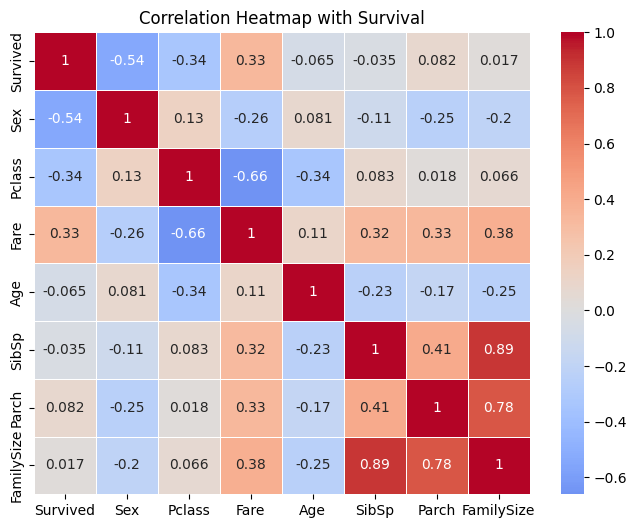

Correlation with survival:
 Survived      1.000000
Fare          0.329862
Parch         0.081629
FamilySize    0.016639
SibSp        -0.035322
Age          -0.064910
Pclass       -0.338481
Sex          -0.543351
Name: Survived, dtype: float64


In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8,6))

corr = df[["Survived", "Sex", "Pclass", "Fare", "Age", "SibSp", "Parch"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap with Survival")
plt.show()

surv_corr = corr["Survived"].sort_values(ascending=False)
print("Correlation with survival:\n", surv_corr)

- Survival by gender: Women survived more than men.
- Survival by class: Higher class → higher chance of survival.
- Age distribution: Children had better survival odds.
- Heatmap of correlations: Sex, Pclass, Fare strongly correlated with survival.
    - Sex &rarr; strong negative correlation (since male=1, female=0 → being male reduces survival chance).
    - Pclass &rarr; negative correlation (higher class → better survival).
    - Fare &rarr; positive correlation (wealthier passengers had better odds).
    - Other features (Age, SibSp, Parch) have weaker correlations

In [66]:
# Features & target
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"]

X.head()
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


##### Logistic Regression

Accuracy: 0.8379888268156425
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



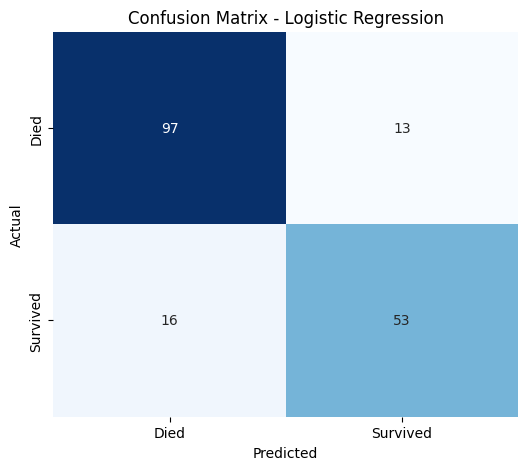

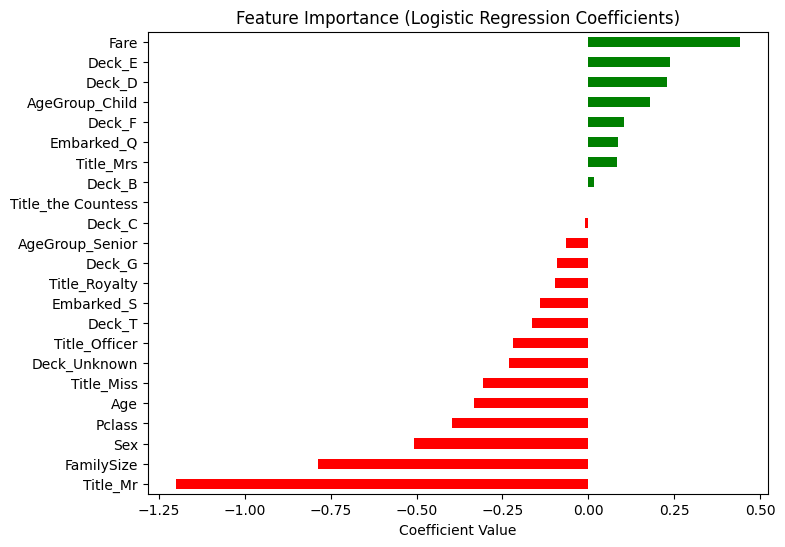

In [67]:
# Scale & train logistic regression
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Died","Survived"], yticklabels=["Died","Survived"],cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Feature importance
coefficients = pd.Series(logreg.coef_[0], index=X_train.columns)
coefficients = coefficients.sort_values()

plt.figure(figsize=(8,6))
coefficients.plot(kind="barh", color=["red" if c<0 else "green" for c in coefficients])
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()

##### Random Forest

Random Forest Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



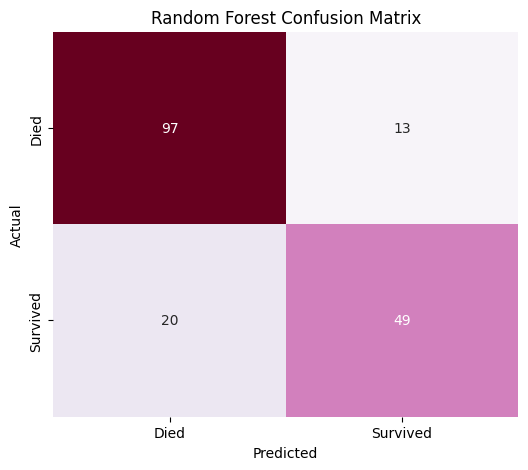

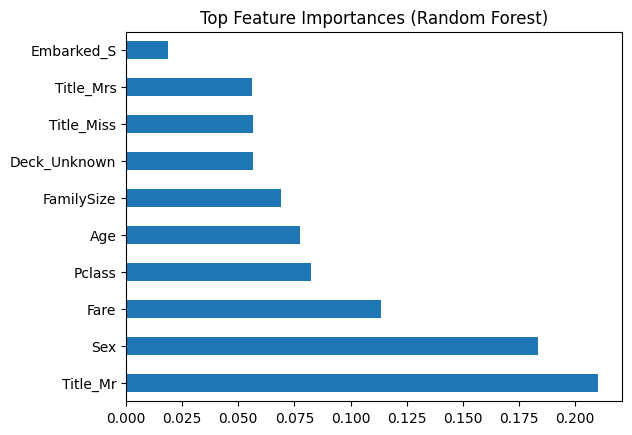

In [68]:
rf = RandomForestClassifier(n_estimators=400, max_depth=6, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd", xticklabels=["Died","Survived"], yticklabels=["Died","Survived"],cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Random Forest Confusion Matrix")
plt.show()


# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances.head(10).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.show()

##### XGBoost

XGBoost Accuracy: 0.8324022346368715

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



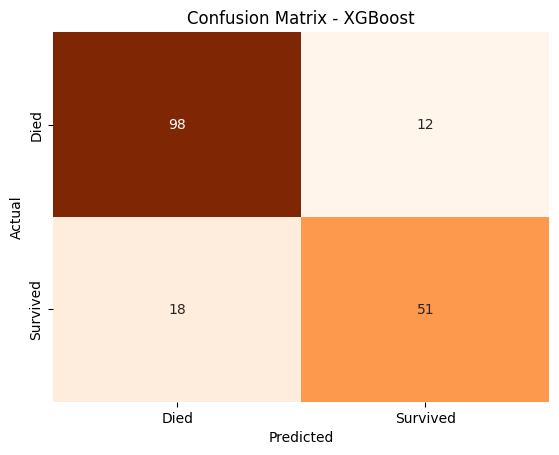

In [69]:
xgb = XGBClassifier(
    n_estimators=300, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges",xticklabels=["Died","Survived"], yticklabels=["Died","Survived"], cbar=False)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Compare models
models = {
    'Logistic Regression': LogisticRegression(max_iter = 200,class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10, random_state=42),
    'Random Forest' : RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier( n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42,eval_metric="logloss")
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,average = "weighted")
    
    results.append([name, acc, prec, rec, f1])
    results.sort(reverse=True)

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.843575,0.825397,0.753623,0.842097
1,Random Forest,0.821229,0.803279,0.710145,0.818865
2,Logistic Regression,0.815642,0.743243,0.797101,0.816722
3,Decision Tree,0.804469,0.854167,0.594203,0.795441


### Inference

- The Titanic dataset contains demographic and ticket-related passenger information.
- Missing values were mainly in `Age`, `Embarked`, and `Cabin`. We imputed `Age` with the median, 
  `Embarked` with the mode, and dropped `Cabin` due to excessive missingness.
- Engineered features `FamilySize` and `IsAlone` added insights into group vs. solo travel.
- EDA revealed:
  - Women had much higher survival rates than men.
  - Children had much higher survival rates as given high priority under such events of ship sinking.
  - Higher passenger classes (1st class) had better survival chances.
  - Being alone decreased the chance of survival thus family size influenced survival.
- Logistic Regression achieved a reasonable accuracy (~78–82%), showing clear patterns in the data.
- Future improvements could include more sophisticated models (Random Forest, Gradient Boosting) 
  and tuning hyperparameters for higher accuracy.

- Future improvements tried:
    - Random Forest improved performance, capturing nonlinear interactions and giving better recall for survivors.
    - XGBoost provides the best balance of accuracy and generalization on Titanic data.